# Absorbing boundary

This script demonstrates the utility of the absorbing boundary, which is an imaginary addition to the potential, to simulate the evolution of bounded potentials (e.g., such as a soft-core Coulomb potential, a Morse potential that has a bounded arm).

In [1]:
"""
import os

threads = 2
os.environ["OMP_NUM_THREADS"] = '{}'.format(threads)
os.environ['NUMEXPR_MAX_THREADS']='{}'.format(threads)
os.environ['NUMEXPR_NUM_THREADS']='{}'.format(threads)
os.environ['OMP_NUM_THREADS'] = '{}'.format(threads)
os.environ['MKL_NUM_THREADS'] = '{}'.format(threads)
"""

'\nimport os\n\nthreads = 2\nos.environ["OMP_NUM_THREADS"] = \'{}\'.format(threads)\nos.environ[\'NUMEXPR_MAX_THREADS\']=\'{}\'.format(threads)\nos.environ[\'NUMEXPR_NUM_THREADS\']=\'{}\'.format(threads)\nos.environ[\'OMP_NUM_THREADS\'] = \'{}\'.format(threads)\nos.environ[\'MKL_NUM_THREADS\'] = \'{}\'.format(threads)\n'

In [2]:
from img_time_prop_1d import imag_time_prop_1d, np
from batch_split_op_1D import BatchSplitOp1D
from scipy.signal import blackman
from scipy import fftpack
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm # enable log color plot
from numba import njit # compile python

In [3]:
# Changing the default size of all the figures 
plt.rcParams['figure.figsize'] = [25, 6]

In [4]:
# Define parameters of an atom (a single-electron model of Ar) in the external laser field

# laser field frequency
omega_laser = 0.06

# the final time of propagation (= 8 periods of laser oscillations)
t_final = 8 * 2. * np.pi / omega_laser

# amplitude of the laser field strength
F = np.array([[0.04], [0.01], [0.03], ])

# the amplitude of grid
x_amplitude = 150.

# the time step
dt = 0.04

@njit
def laser(t):
    """
    The strength of the laser field.
    Always add an envelop to the laser field to avoid all sorts of artifacts.
    We use a sin**2 envelope, which resembles the Blackman filter
    """
    return F * np.sin(omega_laser * t) * np.sin(np.pi * t / t_final)

@njit
def v_columb(x):
    """
    Potential energy: The soft core Columb potential.
    """
    return -1. / np.sqrt(x ** 2 + 1.37)


@njit
def v(x, t):
    """
    Potential energy.
    
    Define the  potential energy as a sum of the soft core Columb potential
    and the laser field interaction in the dipole approximation.
    """
    return -1. / np.sqrt(x ** 2 + 1.37) + x * laser(t)

@njit
def diff_v(x, t):
    """
    the derivative of the potential energy
    """
    return x * (x ** 2 + 1.37) ** (-1.5) + laser(t)

@njit
def k(p):
    """
    Non-relativistic kinetic energy
    """
    return 0.5 * p ** 2
                                                
@njit
def diff_k(p):
    """
    the derivative of the kinetic energy for Ehrenfest theorem evaluation
    """
    return p

@njit
def abs_boundary(x):
    """
    Absorbing boundary similar to the Blackman filter
    """
    return np.sin(0.5 * np.pi * (x + x_amplitude) / x_amplitude) ** (0.02 * dt)

sys_params = dict(
    batch_size=3,
    
    dt=dt,
    x_grid_dim=2 * 1024,
    x_amplitude=x_amplitude,
    
    abs_boundary=abs_boundary,
    
    k=k,
    
    # coment out these to speed up code
    diff_k=diff_k,
    diff_v=diff_v,
)

In [5]:

#########################################################################
#
#   Define functions for testing and visualizing
#
#########################################################################


def test_propagation(sys):
    """
    Run tests for the specified propagators and plot the probability density
    of the time dependent propagation
    :param sys: class that propagates
    """
    iterations = 748
    steps = int(round(t_final / sys.dt / iterations))

    # propagate and save the densities
    batch_density = [np.abs(sys.propagate(steps)) ** 2 for _ in range(iterations)]
    batch_density = np.swapaxes(batch_density, 0, 1)
    
    # plot density of each system in the batch separately  
    for density in batch_density:
        # display the propagator
        plt.imshow(
            density,
            origin='lower',
            norm=LogNorm(vmin=1e-12, vmax=0.1),
            aspect=0.4, # image aspect ratio
            extent=[sys.x.min(), sys.x.max(), 0., sys.t]
        )
        plt.xlabel('coordinate $x$ (a.u.)')
        plt.ylabel('time $t$ (a.u.)')
        plt.colorbar()
        plt.show()


def test_Ehrenfest1(sys):
    """
    Test the first Ehenfest theorem for the specified quantum system
    """
    # plot Ehrenfest relations of each system in the batch separately 
    for x_average, x_average_rhs in zip(np.swapaxes(sys.x_average, 0, 1), np.swapaxes(sys.x_average_rhs, 0, 1)):
    
        dx_dt = np.gradient(x_average, sys.dt)

        print("Error in Ehrenfest relations: {:.2e}".format(np.linalg.norm(dx_dt - x_average_rhs)))

        plt.plot(sys.times, dx_dt, '-r', label='$d\\langle\\hat{x}\\rangle / dt$')
        plt.plot(sys.times, x_average_rhs, '--b', label='$\\langle\\hat{p}\\rangle$')
        plt.legend()
        plt.ylabel('momentum')
        plt.xlabel('time $t$ (a.u.)')
        plt.show()


def test_Ehrenfest2(sys):
    """
    Test the second Ehenfest theorem for the specified quantum system
    """
    # plot Ehrenfest relations of each system in the batch separately 
    for p_average, p_average_rhs in zip(np.swapaxes(sys.p_average, 0, 1), np.swapaxes(sys.p_average_rhs, 0, 1)):
        
        dp_dt = np.gradient(p_average, sys.dt)

        print("Error in Ehrenfest relations: {:.2e}".format(np.linalg.norm(dp_dt - p_average_rhs)))

        plt.plot(sys.times, dp_dt, '-r', label='$d\\langle\\hat{p}\\rangle / dt$')
        plt.plot(sys.times, p_average_rhs, '--b', label='$\\langle -U\'(\\hat{x})\\rangle$')
        plt.legend()
        plt.ylabel('force')
        plt.xlabel('time $t$ (a.u.)')
        plt.show()

### Get the ground states

In [6]:
ground_state = imag_time_prop_1d(
    v=v_columb, 
    **sys_params,
)[0]


Starting imaginary time propagation


Final current ground state energy = -5.8699e-01


### Propagate

In [7]:
qsys = BatchSplitOp1D(v=v, **sys_params).set_wavefunction(ground_state)

## Test propagation in the context of High Harmonic Generation

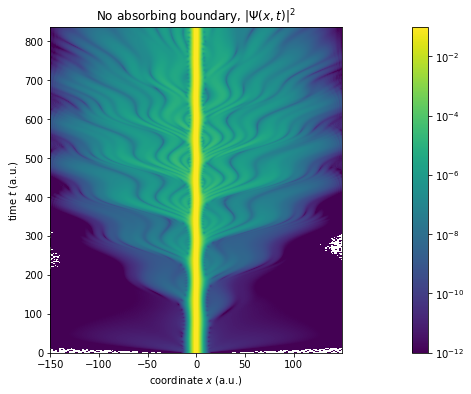

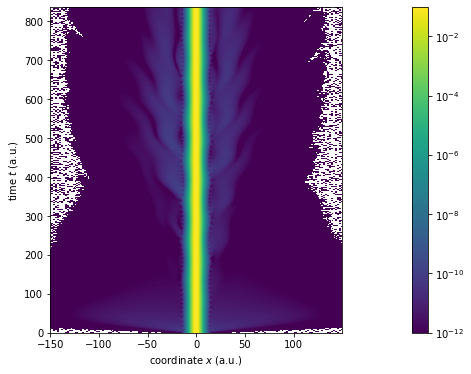

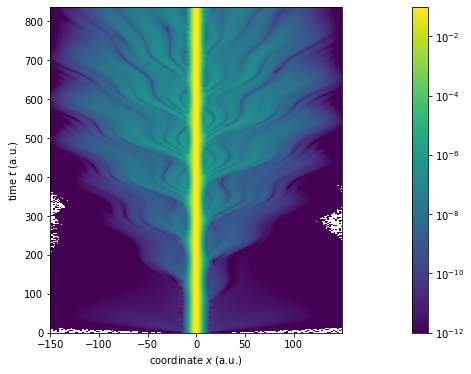

CPU times: user 33.9 s, sys: 10.2 s, total: 44.1 s
Wall time: 31.7 s


In [8]:
plt.title("No absorbing boundary, $|\\Psi(x, t)|^2$")
%time test_propagation(qsys)

## Test the first Ehrenfest theorems

Error in Ehrenfest relations: 1.57e-03


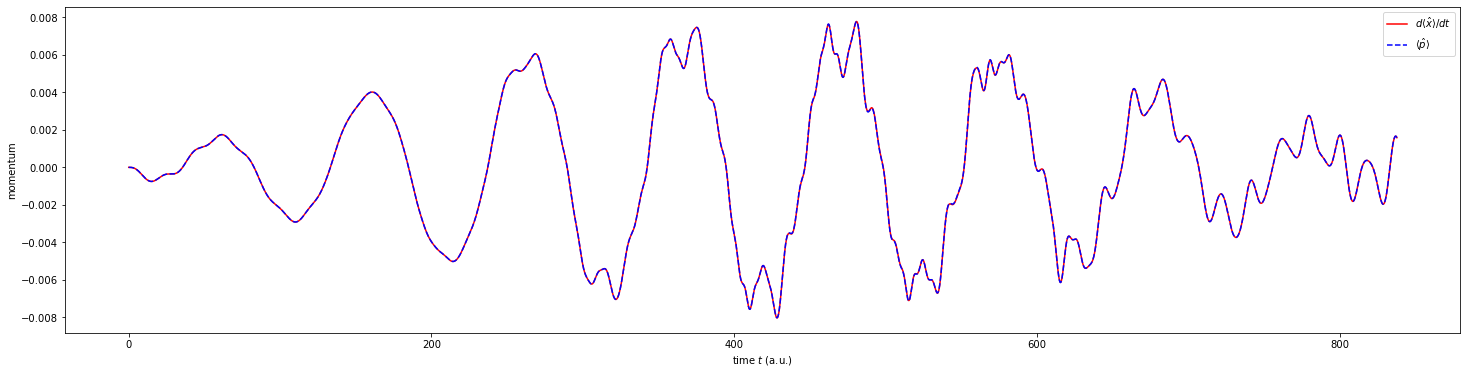

Error in Ehrenfest relations: 4.30e-05


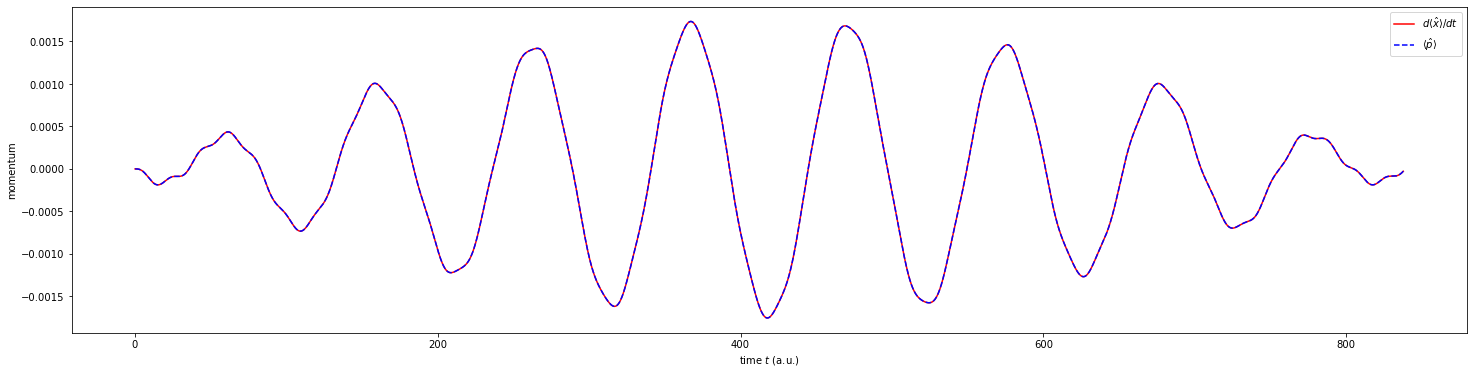

Error in Ehrenfest relations: 1.14e-04


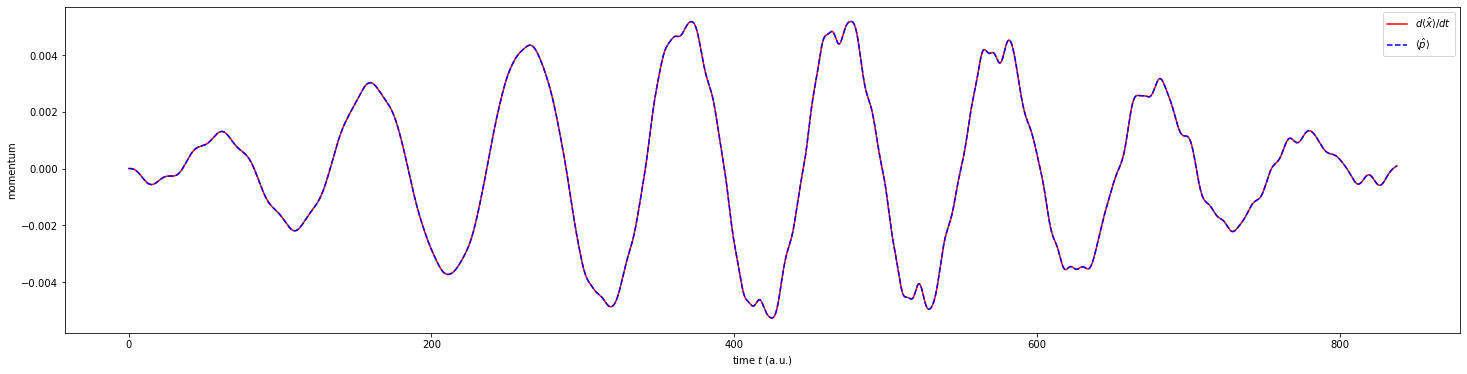

In [9]:
test_Ehrenfest1(qsys)

## Test the second Ehrenfest theorems

Error in Ehrenfest relations: 3.32e-05


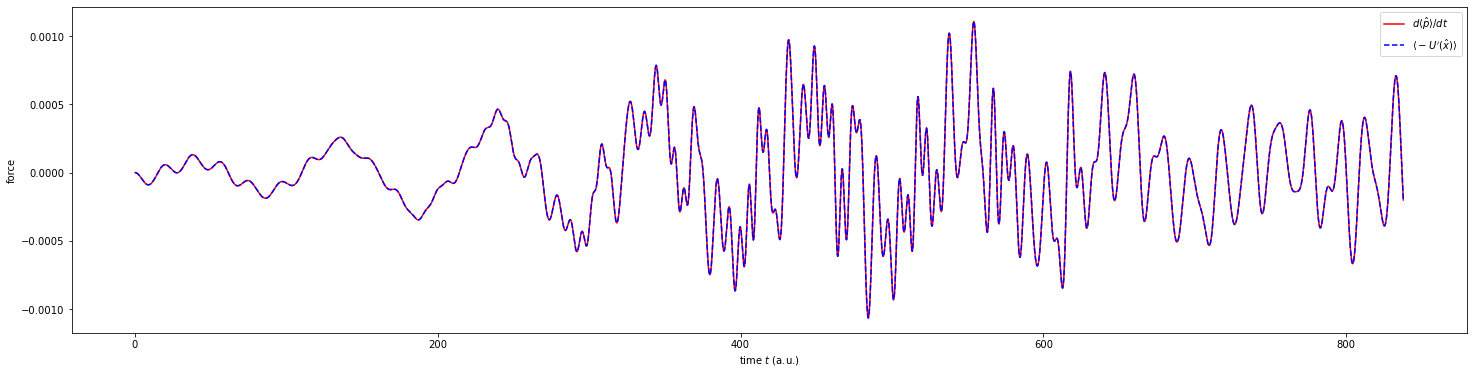

Error in Ehrenfest relations: 3.84e-07


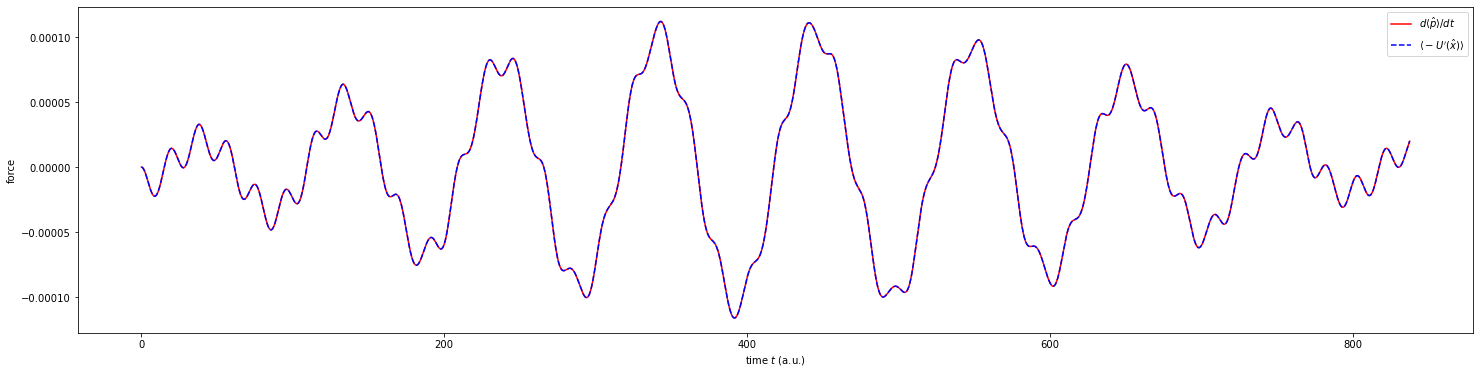

Error in Ehrenfest relations: 1.65e-06


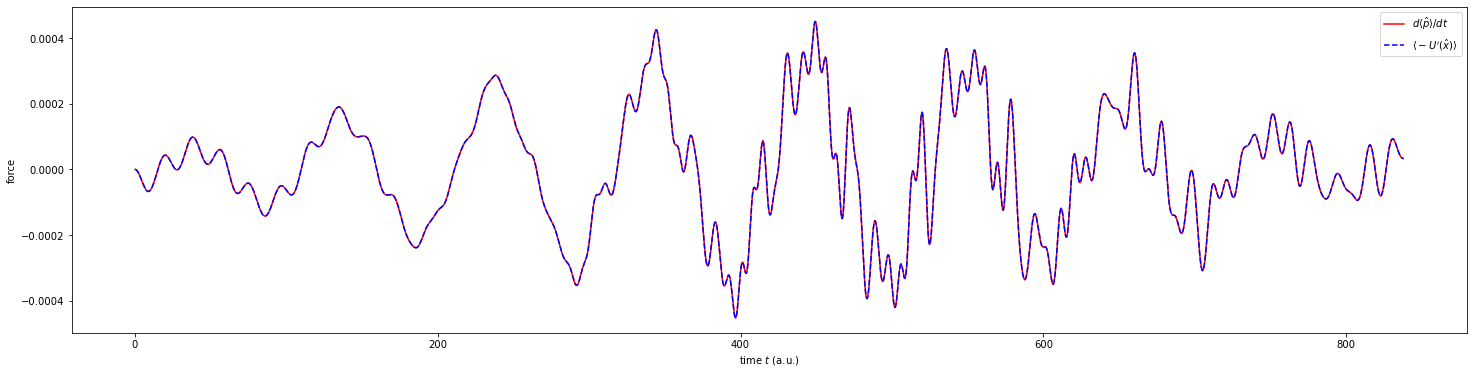

In [10]:
test_Ehrenfest2(qsys)

## HHG Spectrum

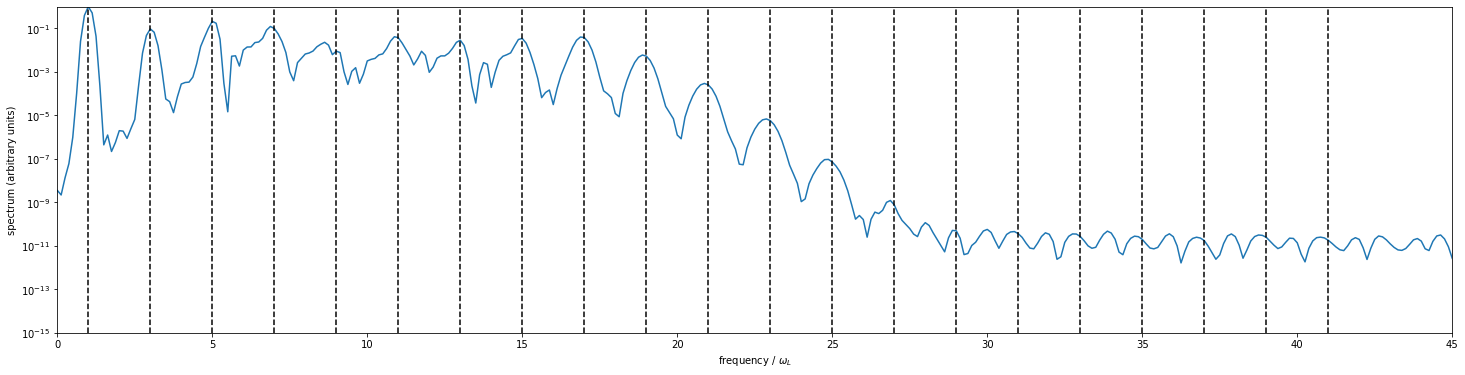

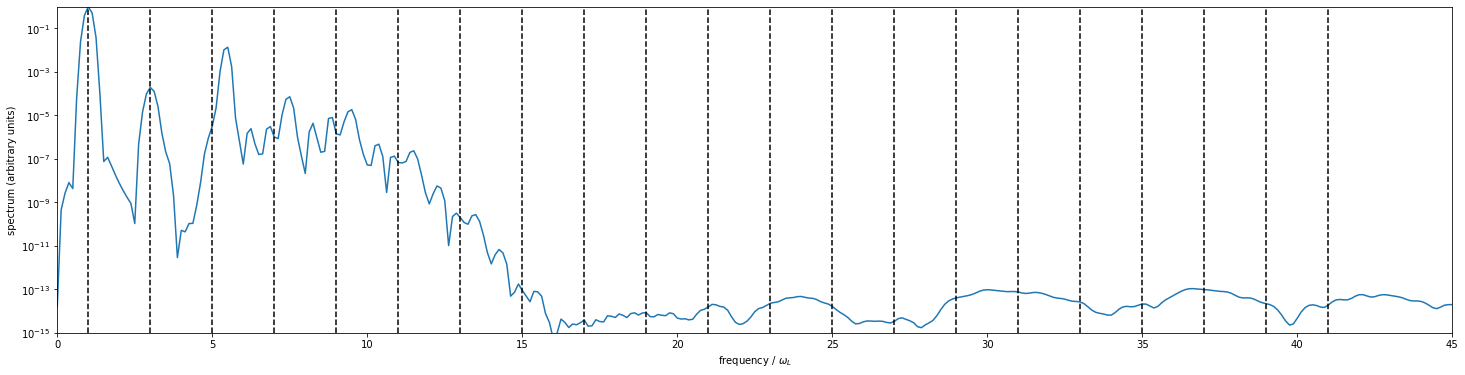

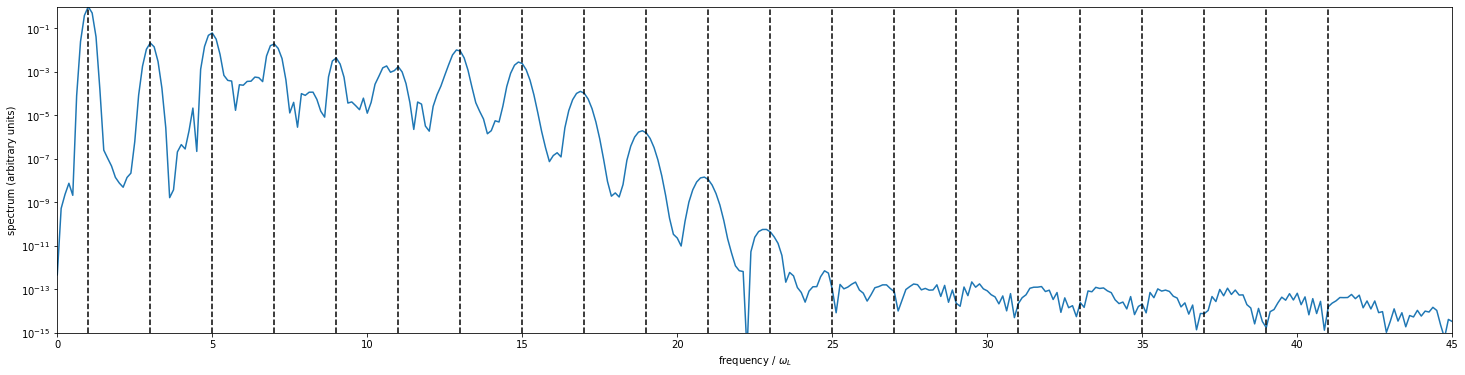

In [15]:
def plot_spectrum(sys):
    """
    Plot the High Harmonic Generation spectrum
    """
    # Power spectrum emitted is calculated using the Larmor formula
    #   (https://en.wikipedia.org/wiki/Larmor_formula)
    # which says that the power emitted is proportional to the square of the acceleration
    # i.e., the RHS of the second Ehrenfest theorem

    # plot the HHG spectrum for each system in the batch separately 
    for p_average_rhs in np.swapaxes(sys.p_average_rhs, 0, 1):
        N = len(p_average_rhs)
        k = np.arange(N)

        # frequency range
        omegas = (k - N / 2) * np.pi / (0.5 * sys.t)

        # spectra of the
        spectrum = np.abs(
            # used windows fourier transform to calculate the spectra
            # rhttp://docs.scipy.org/doc/scipy/reference/tutorial/fftpack.html
            fftpack.fft((-1) ** k * blackman(N) * p_average_rhs)
        ) ** 2
        spectrum /= spectrum.max()

        plt.semilogy(omegas / omega_laser, spectrum)
        plt.ylabel('spectrum (arbitrary units)')
        plt.xlabel('frequency / $\\omega_L$')
        plt.xlim([0, 45.])
        plt.ylim([1e-15, 1.])
        
        # plot vertical lines corresponding to odd frequencies 
        for k in 2 * np.arange(21) + 1:
            plt.axvline(k, linestyle='--', color='black')
        
        plt.show()

        
plot_spectrum(qsys)